#### Customer Segmentation  
Feature Engineering  
->Mean of order_dow (order placed day of week)  
-> Mean of order_hour_of_day  
->Mean of days_since_prior_order  
->Total number of orders made  
->Total number of products bought  

Look at the distribution of these variables and perform any standardising or transformations required to the variables.  

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.stats.power import TTestIndPower, TTestPower

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer

In [2]:
aislesDF = pd.read_csv('data/aisles.csv')
departmentDF = pd.read_csv('data/departments.csv')
Order_Products_Prior_DF = pd.read_csv('data/order_products__prior.csv')
Order_Products_Train_DF = pd.read_csv('data/order_products__train.csv')
ordersDF = pd.read_csv('data/orders.csv')
productsDF = pd.read_csv('data/products.csv')

In [4]:
# Prior orders with order_id
Order_Product_Prior = pd.merge(Order_Products_Prior_DF, 
                                    ordersDF, how='left', on='order_id')

In [5]:
Order_Product_Prior.head(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0


In [6]:
# keep only those that same user_id exists in both train and prior
Prior_User_Order_Product_inner = pd.merge(Order_Product_Prior,
                                          ordersDF[ordersDF['eval_set']=='train'][['user_id','eval_set']], 
                                          how='inner', on='user_id')
Prior_User_Order_Product_inner.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set_x,order_number,order_dow,order_hour_of_day,days_since_prior_order,eval_set_y
0,2,33120,1,1,202279,prior,3,5,9,8.0,train
1,2,28985,2,1,202279,prior,3,5,9,8.0,train
2,2,9327,3,0,202279,prior,3,5,9,8.0,train
3,2,45918,4,1,202279,prior,3,5,9,8.0,train
4,2,30035,5,0,202279,prior,3,5,9,8.0,train


In [19]:
user_habit = Prior_User_Order_Product_inner[['user_id','order_id','product_id',
                                       'order_dow',
                                       'order_hour_of_day','days_since_prior_order']]
# Create a dataframe: average value of each user
user_avg = user_habit.groupby('user_id')['order_dow',
                                'order_hour_of_day',
                                'days_since_prior_order'].agg(np.nanmean)
# Total number of orders of each user
user_order = user_habit.groupby('user_id').order_id.nunique()
user_avg['num_of_orders'] = user_order
# Total number of products of each user
product_number = user_habit.groupby('user_id')['product_id'].agg('count')
user_avg['num_of_products'] = product_number
user_avg.head(2)

C:\Users\nehaa\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


,order_dow,order_hour_of_day,days_since_prior_order,num_of_orders,num_of_products
user_id,,,,,
1,2.644068,10.542373,20.259259,10,59
2,2.005128,10.441026,15.967033,14,195
5,1.621622,15.729730,14.500000,4,37
7,1.728155,13.631068,13.546392,20,206
8,4.204082,2.448980,30.000000,3,49


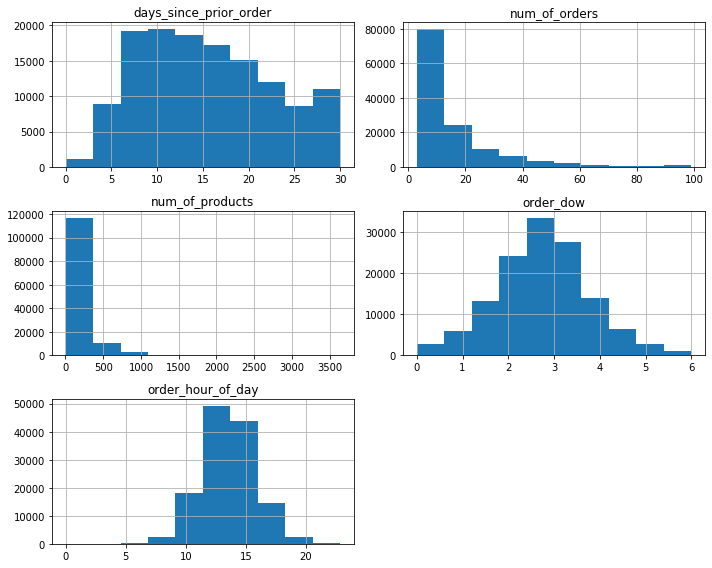

In [26]:
user_avg.hist(figsize=(10,8))
plt.tight_layout();

Data seems skewed for number of orders and number of products. We can use log transformations to address the skeweness

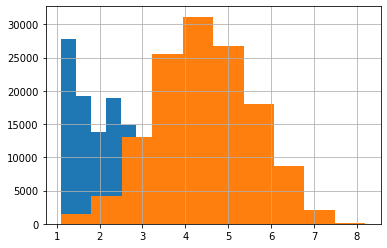

In [28]:
user_avg["num_of_orders"].apply(np.log).hist()
user_avg["num_of_products"].apply(np.log).hist()
plt.show()

In [32]:
scaler = StandardScaler()
user_avg = scaler.fit_transform(user_avg)
user_avgDF = pd.DataFrame(user_avg)
user_avgDF.describe()

,0,1,2,3,4
count,1.312090e+05,1.312090e+05,1.312090e+05,1.312090e+05,1.312090e+05
mean,1.495388e-17,-1.689791e-15,-4.496467e-16,-2.529694e-16,7.582125e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-2.706069e+00,-6.103038e+00,-2.146298e+00,-7.564928e-01,-7.582290e-01
25%,-6.284849e-01,-6.506317e-01,-8.220718e-01,-6.364521e-01,-5.813499e-01
50%,2.577495e-04,-9.428962e-03,-1.067491e-01,-3.963707e-01,-3.651643e-01
75%,6.088576e-01,6.404724e-01,7.291721e-01,2.038329e-01,1.556465e-01
max,3.198644e+00,4.193780e+00,2.016581e+00,5.005461e+00,1.710165e+01


In [52]:
user_avgDF.head()

,0,1,2,3,4
0,-0.103992,-1.352976,0.664930,-0.336350,-0.483084
1,-0.732785,-1.398640,0.069330,-0.096269,0.185126
2,-1.110201,0.984285,-0.134240,-0.696472,-0.591177
3,-1.005359,0.038693,-0.266565,0.263853,0.239173
4,1.431247,-4.999605,2.016581,-0.756493,-0.532217


In [38]:
def kmeans(df, clusters_number):
    '''
    Implement k-means clustering on dataset
    
    INPUT:
        dataset : dataframe. Dataset for k-means to fit.
        clusters_number : int. Number of clusters to form.
        end : int. Ending range of kmeans to test.
    OUTPUT:
        Cluster results and t-SNE visualisation of clusters.
    '''   
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(df)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = df.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], 
                    hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new, cluster_labels

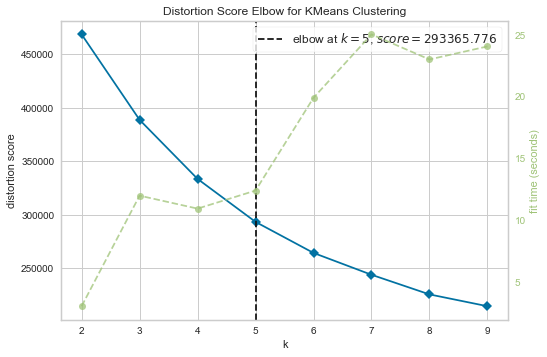

In [35]:
# Visualize performance of KMeans at various values k
# This approaches uses distortion score to evaluate KMeans
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10))

visualizer.fit(user_avgDF)   
visualizer.show();

Elbow plot shows optimal value of clusters is 5. We can check clustering visualizations for 4,5 and 6

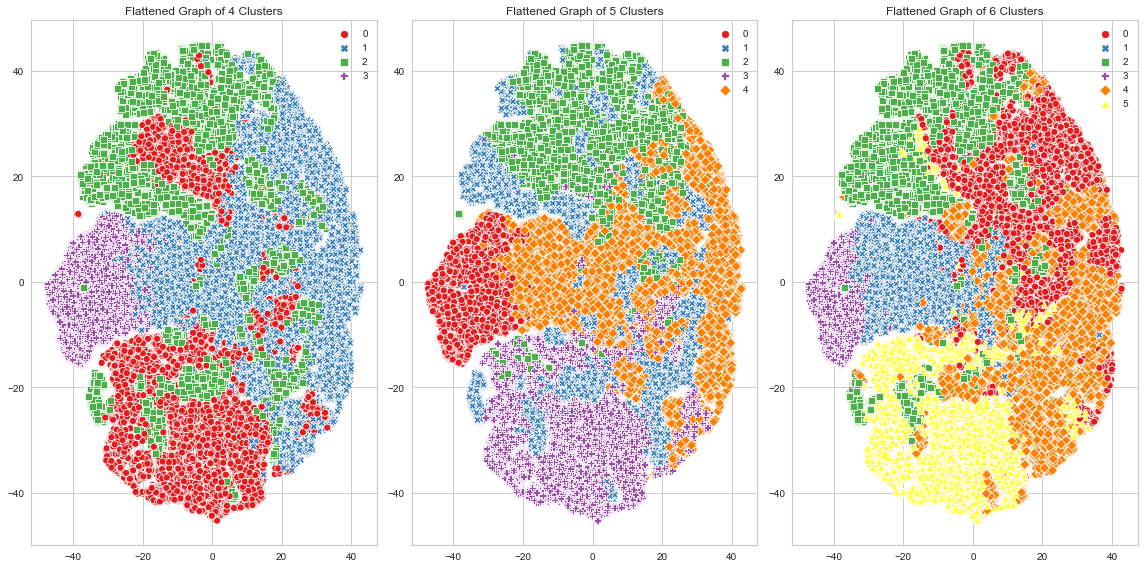

In [42]:

# Create subplots for various k clusters
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
k3 = kmeans(user_avgDF, 4)

plt.subplot(1, 3, 2)
k4 = kmeans(user_avgDF, 5)

plt.subplot(1, 3, 3)
k5 = kmeans(user_avgDF, 6)

plt.tight_layout()

By looking all three cluster plots we can say we have overlapping in all the cases. To overcome this we will check with cluster numbers as 3

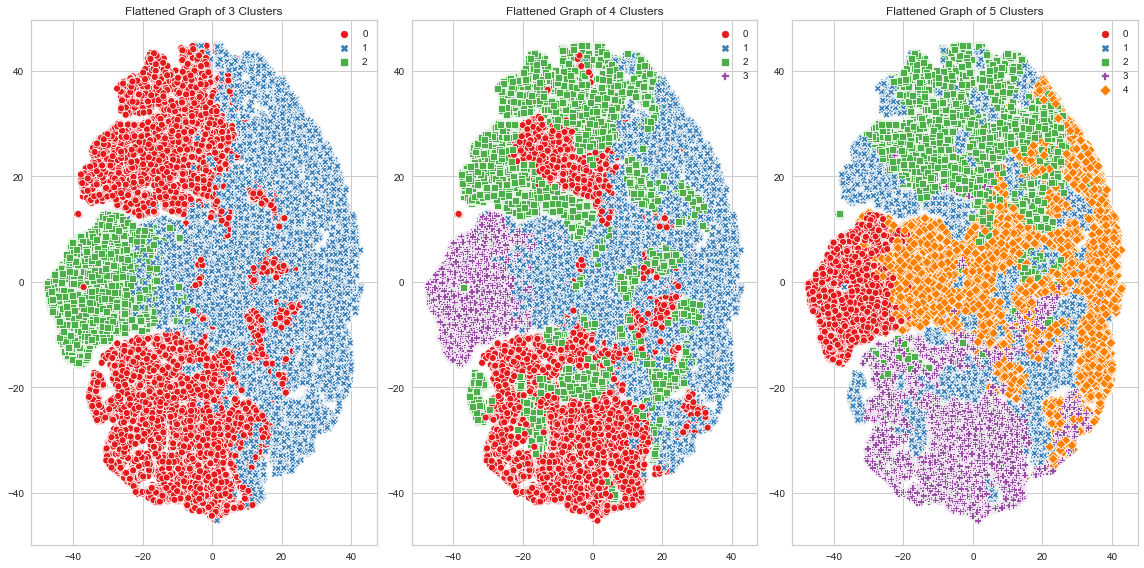

In [43]:
# Create subplots for various k clusters
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
k3 = kmeans(user_avgDF, 3)

plt.subplot(1, 3, 2)
k4 = kmeans(user_avgDF, 4)

plt.subplot(1, 3, 3)
k5 = kmeans(user_avgDF, 5)

plt.tight_layout()

In [51]:

# Convert clusters to DataFrame with appropriate index and column names
user_avg= pd.DataFrame(user_avg)
cluster_df = pd.DataFrame(k3[0])
cluster_df.index = user_avg.index
cluster_df.columns = ['order_dow', 'order_hour_of_day', 
                      'days_since_prior_order', 'num_of_orders','num_of_products','Cluster']
cluster_df.head()

,order_dow,order_hour_of_day,days_since_prior_order,num_of_orders,num_of_products,Cluster
0,-0.103992,-1.352976,0.664930,-0.336350,-0.483084,0
1,-0.732785,-1.398640,0.069330,-0.096269,0.185126,1
2,-1.110201,0.984285,-0.134240,-0.696472,-0.591177,0
3,-1.005359,0.038693,-0.266565,0.263853,0.239173,1
4,1.431247,-4.999605,2.016581,-0.756493,-0.532217,0


In [53]:
cluster_melt = pd.melt(cluster_df.reset_index(),
                       id_vars=['Cluster'],
                       value_vars=['order_dow', 
                                   'order_hour_of_day', 
                                   'days_since_prior_order','num_of_orders','num_of_products'],
                       var_name='Metric',
                       value_name='Value')

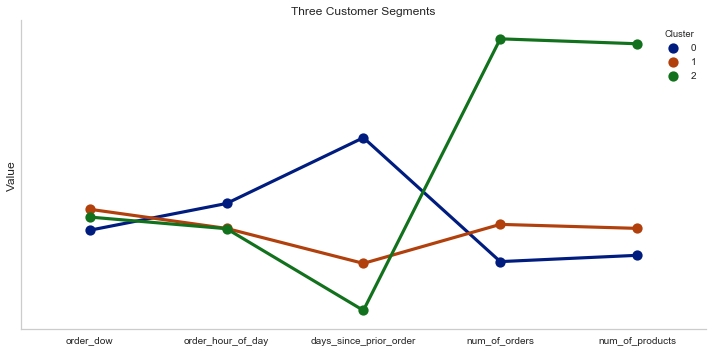

In [59]:
# Analysing each cluster
plt.figure(figsize=(10,5))
sns.pointplot(x='Metric', y='Value', data=cluster_melt, hue='Cluster', 
              palette=sns.color_palette("dark"))
plt.xlabel('',fontsize=12)
plt.ylabel('Value',fontsize=12)
plt.yticks([])
plt.title('Three Customer Segments')
sns.despine()
plt.tight_layout()
plt.show();